# Notebook for Manifolder

Demonstration of the manifold reconstruction technique, using test data and space weather data.

The `simplified_data.csv` contains 8 channels of timeseries test data.  For simplicity, only the first channel contains the test signal, which contains a few different, repeating signal types.  All channels have low-level noise added, for numerical stability.

Running the `Manifolder` code with `Dim=3` projects the signal into an an underlying 3-dimensional manifold.  Plotting the signal, along with the underlying dimensions, gives a simple visual representation of the technique.

### Resources

[NumPy for Matlab users — NumPy v1.13 Manual](https://docs.scipy.org/doc/numpy-1.13.0/user/numpy-for-matlab-users.html)

[Getting Started with MATLAB](https://www.mathworks.com/help/matlab/getting-started-with-matlab.html)

### Running

This port strives to be as similar to the original MATLAB code as possible.  MATLAB code frequently runs the files inline, as scripts.  To do this in Python, we use the `exec()` command.

Executing files from within a notebook is useful for demonstration and debugging, since all the variables are avaible in the base naming space.

To run the code from the notebook, add the folder containing the python code (here, `manifolder_pkg`) directory the `PYTHONPATH`.  An example in Bash would be:

```bash
PYTHONPATH=${PYTHONPATH}:~/Documents/repos/manifolder_repo/manifolder_pkg
```


In [1]:
!echo $PYTHONPATH


/Users/jonathan/Documents/repos:./:/Users/jonathan/Documents/repos/manifolder_repo/manifolder_pkg


In [2]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns

sns.set()

import pandas as pd

import time

### Run Manifolder

Run the code, using the sklearn-like interface, on sample data and solar wind data

In [3]:
import manifolder as mr
import manifolder_helper as mh


loaded data/simple_data.csv, shape: (8, 87660)
calculating histograms for 8 dimensions (univariate timeseries) ........ done
computing local covariances .......... done
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
running k-means
(17532,)
normalizing amplitudes of Psi in Python ...
(17524,)
done


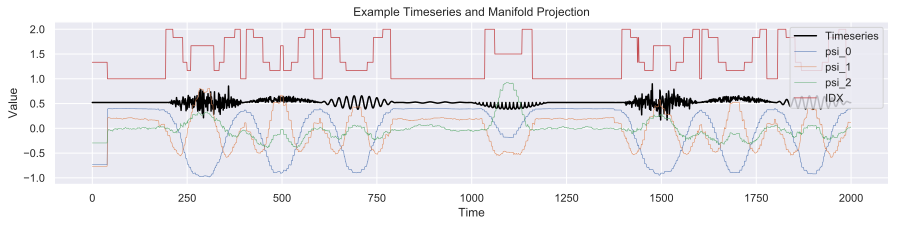

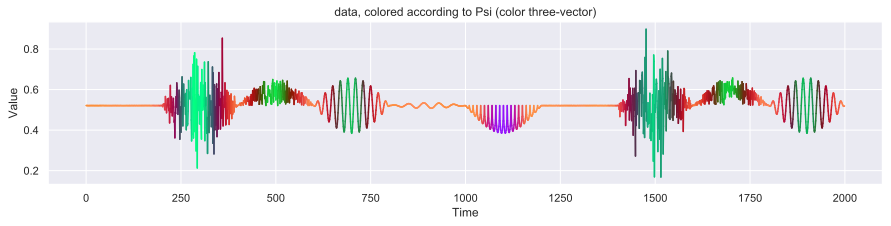


	 Program Executed in 248.1 seconds


In [4]:
# run the manifolder ... note, all functions are currently executed
# by the fit() function, which is the equivalent of calling
#
#        manifolder._load_data(X)
#        manifolder._histograms_overlap()
#        manifolder._covariances()
#        manifolder._embedding()
#        manifolder._clustering()
#
# since this data on file is formatted 'columns as observations,'
# in must be transposed before being passed in
#

start_time = time.time()

# load the data
data_location = 'data/simple_data.csv'
df = pd.read_csv(data_location, header=None)
z = df.values
print('loaded',data_location + ', shape:', z.shape)

# create manifolder object
manifolder = mr.Manifolder()

# add the data, and fit (this runs all the functions)
manifolder.fit( z.T )

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')   # about 215 seconds (four minutes)


In [5]:
# IDX contains the index of clusters (typically ~7) ...
# need to make a dictionary, with a key for each index (0 to 6),
# the value is a list of the collection of lengths

cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

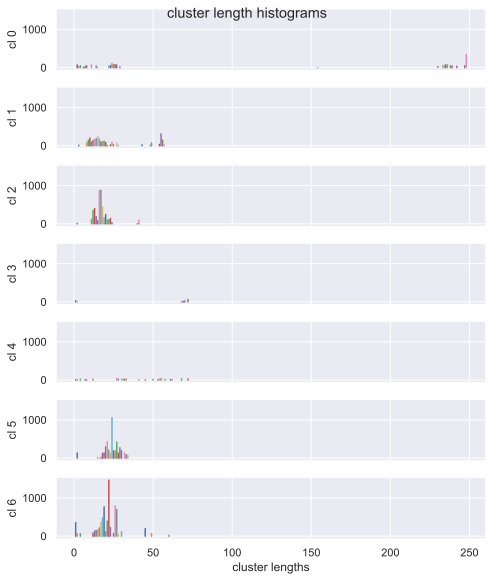

In [6]:
# clustering data ...

IDX = manifolder.IDX

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens)


### Graph Transition (Markov) Matrix

The system can be though of as in one particular "state" (cluster value) at any given time.  This state $S$ can be though of as a column vector with $C$ dimensions, similar to states in quantum mechanic, where the column vector plays the role of the transition matrix.

Time evolution is this given by the tranistion matrix $M$, which is a Markov matrix (all columns sum to one, to preserve probability).  In this case, we have

$$
S_{n+1} = M @ S_n 
$$

Where the $@$ symbol is used to explicitly denote matrix multiplication.

Since most clusters with transition to themselves, the diagonal values of the matrix can be quite high, and are typically removed.  Thus, for visualization, we remove the diagonal elements of the matrix.

In [7]:
# in this case, index goes from 0 to 6 ... 
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)


(17524,)
0
6


In [8]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[7344.    0.    1.    0.    0.    0.   55.]
 [   0. 1683.   45.    0.   28.    0.    0.]
 [   0.   45. 1460.    0.    0.   46.    0.]
 [   0.    0.    0.  978.    0.    0.   17.]
 [   0.   28.    0.    0. 1074.    0.    0.]
 [   0.    0.   45.    0.    0. 2080.   47.]
 [  56.    0.    0.   17.    0.   46. 2428.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[7344.   55.    0.    0.    1.    0.    0.]
 [  56. 2428.   46.    0.    0.    0.   17.]
 [   0.   47. 2080.    0.   45.    0.    0.]
 [   0.    0.    0. 1683.   45.   28.    0.]
 [   0.    0.   46.   45. 1460.    0.    0.]
 [   0.    0.    0.   28.    0. 1074.    0.]
 [   0.   17.    0.    0.    0.    0.  978.]]


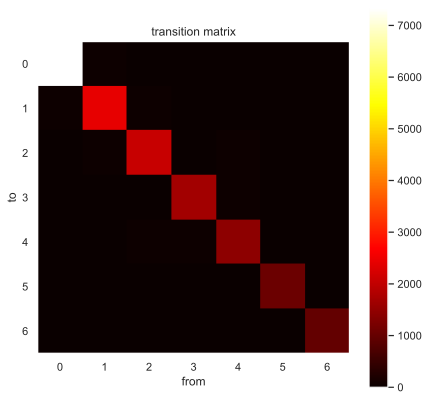

In [9]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.4622 0.     0.     0.011  0.     0.    ]
 [1.     0.     0.5    0.     0.     0.     1.    ]
 [0.     0.395  0.     0.     0.4945 0.     0.    ]
 [0.     0.     0.     0.     0.4945 1.     0.    ]
 [0.     0.     0.5    0.6164 0.     0.     0.    ]
 [0.     0.     0.     0.3836 0.     0.     0.    ]
 [0.     0.1429 0.     0.     0.     0.     0.    ]]


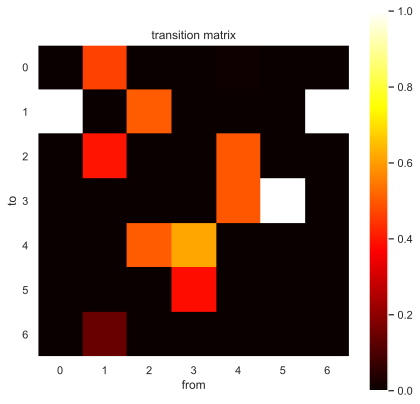

In [10]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### Run code again, on solar wind

loaded data/solar_wind_data.csv, shape: (8, 87660)
calculating histograms for 8 dimensions (univariate timeseries) ........ done
computing local covariances .......... done
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
running k-means
(17532,)
normalizing amplitudes of Psi in Python ...
(17524,)
done


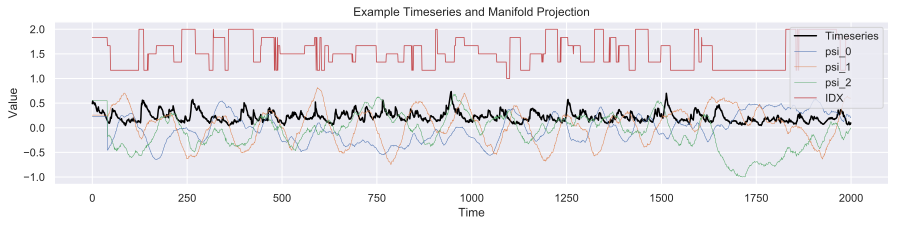

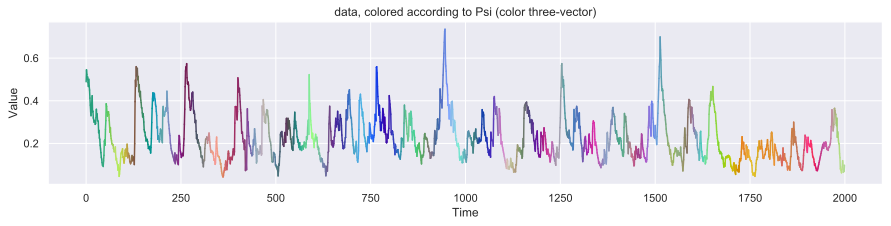


	 Program Executed in 249.99 seconds


In [12]:
# run the manifolder ... note, all functions are currently executed
# by the fit() function, which is the equivalent of calling
#
#        manifolder._load_data(X)
#        manifolder._histograms_overlap()
#        manifolder._covariances()
#        manifolder._embedding()
#        manifolder._clustering()
#
# since this data on file is formatted 'columns as observations,'
# in must be transposed before being passed in
#

start_time = time.time()

# load the data
data_location = 'data/solar_wind_data.csv'
df = pd.read_csv(data_location, header=None)
z = df.values
print('loaded',data_location + ', shape:', z.shape)

# create manifolder object
manifolder = mr.Manifolder()

# add the data, and fit (this runs all the functions)
manifolder.fit( z.T )

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')   # about 215 seconds (four minutes)


cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

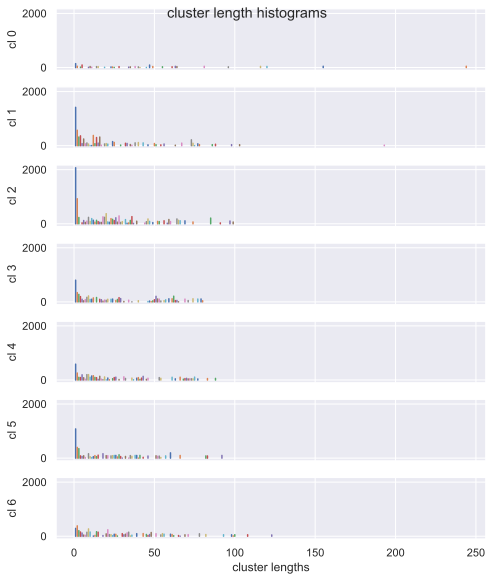

In [13]:
# clustering data ...

IDX = manifolder.IDX

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens)


In [14]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[1697.    0.   17.    0.    0.   15.   16.]
 [   0. 2382.    4.   20.   24.   40.   25.]
 [  14.    3. 2794.   43.   26.   19.   32.]
 [   0.   24.   36. 2774.   31.    0.   16.]
 [   0.   21.   32.   28. 2581.   16.    0.]
 [  25.   30.   19.    0.   16. 1825.   10.]
 [   9.   35.   29.   16.    0.   10. 2769.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[2794.   43.   32.   26.    3.   19.   14.]
 [  36. 2774.   16.   31.   24.    0.    0.]
 [  29.   16. 2769.    0.   35.   10.    9.]
 [  32.   28.    0. 2581.   21.   16.    0.]
 [   4.   20.   25.   24. 2382.   40.    0.]
 [  19.    0.   10.   16.   30. 1825.   25.]
 [  17.    0.   16.    0.    0.   15. 1697.]]


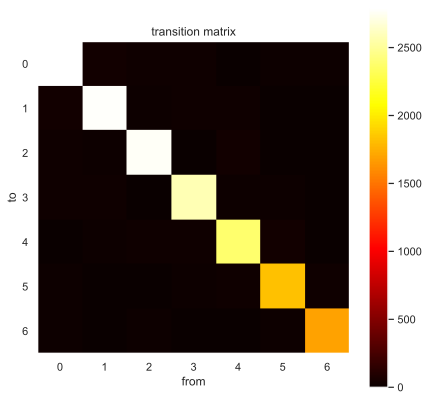

In [15]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.4019 0.3232 0.268  0.0265 0.19   0.2917]
 [0.2628 0.     0.1616 0.3196 0.2124 0.     0.    ]
 [0.2117 0.1495 0.     0.     0.3097 0.1    0.1875]
 [0.2336 0.2617 0.     0.     0.1858 0.16   0.    ]
 [0.0292 0.1869 0.2525 0.2474 0.     0.4    0.    ]
 [0.1387 0.     0.101  0.1649 0.2655 0.     0.5208]
 [0.1241 0.     0.1616 0.     0.     0.15   0.    ]]


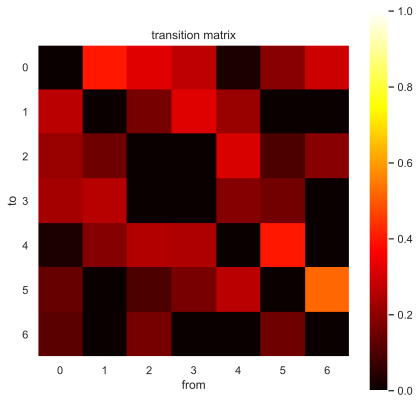

In [16]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### Packaging

In [ ]:
assert False, 'code stops here (experimental code below)'


Inspect existing sklearn code, for structure

[sklearn.linear_model.LinearRegression — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)



In [ ]:

import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
# 1.0
reg.coef_
# array([1., 2.])
reg.intercept_
# 3.0000...
reg.predict(np.array([[3, 5]]))
#array([16.])


[How does python find packages_ __ Lee On Coding __ My blog about coding and stuff.](https://leemendelowitz.github.io/blog/how-does-python-find-packages.html)



In [ ]:
import imp
imp.find_module('sklearn')
#(None, '/usr/local/lib/python2.7/dist-packages/numpy', ('', '', 5))

In [ ]:
# think this brings in everything from the __init__.py?
import sklearn.linear_model as lm

### tSNE

In [ ]:
assert False, 'stop here'

In [ ]:
from sklearn.manifold import TSNE

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
print('X.shape', X.shape)
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)


In [ ]:
# number of dimensions are assumed to be number of rows, for TSNE
# (use transpose)

start_time = time.time()

# shorten by five
# this is set by a "stride" somewhere?
z_short = z[:, ::5]
print('z.shape', z.shape)
print('z_short.shape', z_short.shape)

z_embedded = TSNE(n_components=3).fit_transform(z_short.T)

elapsed = time.time() - start_time

print('elapsed mins:', np.round(elapsed / 60, 2))


In [ ]:
print('z_embedded.shape', z_embedded.shape)

plt.figure(figsize=[15, 3])

xref = z[0, :lim]
# from tsne
xs = z_embedded[:lim, 0] / 20  # careful (transposed)
ys = z_embedded[:lim, 1] / 20
zs = z_embedded[:lim, 2] / 20

# from manifolder
# xs = Psi[:lim, 0]   # this is shapped differently ...
# ys = Psi[:lim, 1] # this is shapped differently ...
# zs = Psi[:lim, 2] # this is shapped differently ...

plt.plot(xref, color='black', label='Timeseries')
plt.plot(xs, linewidth=.5, label='$\psi_0$')
plt.plot(ys, linewidth=.5, label='$\psi_1$')
plt.plot(zs[:lim], linewidth=.5, label='$\psi_2$')

# plt.plot(IDX[:lim]/np.max(IDX)+1,linewidth=.8,label='IDX')

plt.legend()

plt.xlabel('Time $ \\rightarrow $')
plt.ylabel('Value')
